<h1 style="font-size: 40px; margin-bottom: 0px;">13.1 Exploring DESeq2 results</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 98%;"></hr>

In notebook 12-2, we ran DESeq2 on our class dataset and got the results of our differential expression analysis. Today, we'll be playing around with our data, looking at our results in aggregate and pulling out data that we might think is interesting to look at in more detail. We'll set up the MA plot now in Python, but breaking it down into smaller steps to better understand what is going on under the hood when we call up DESeq2's <code>plotMA()</code> function. 

Then we'll set up a volcano plot, which Dr. Ingolia introduced in his differential expression analysis lecture, so that we can visualize the overall transcriptomic changes by plotting the fold change and significance for each gene.  

We'll then pull out specific genes to take a look at in a little more depth by generating violin plots and box-and-whisker plots to take a look at how TAZ KO alters their level of expression.

<strong>Learning objectives:</strong>

<ul>
    <li>Navigate differential expression results</li>
    <li>Practice working with data in Python</li>
    <li>Practice data visualization</li>
    <ul>
        <li>MA plot</li>
        <li>Volcano plot</li>
        <li>Violin plot</li>
        <li>Box-and-whisker plot</li>
    </ul>
</ul>

<h1 style="font-size: 40px; margin-bottom: 0px;">Load in packages</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 98%;"></hr>

For today's plotting, we'll load in a package called <code>adjustText</code> which will allow us to more easily plot a bunch of text without needing to know exactly the text and the positions for which we're plotting. That way, we can pull out relevant information from our data set for plotting and visualization. We'll be able to specify the text objects to plot, and then <code>adjustText</code> will iterate through possible positions to space the text apart and add connecting lines to the data point being annotated. Specifically, we'll make use of it's function <code>adjust_text()</code>.

<a href="https://adjusttext.readthedocs.io/en/latest/" rel="noopener noreferrer"><u>Documentation for <code>adjust_text()</code> can be found here.</u></a>

Since this isn't installed in our Biology Hub, we can go ahead and install it using our notebook.

In [1]:
pip install adjustText

Note: you may need to restart the kernel to use updated packages.


Then let's go ahead and import the packages that we'll use for this notebook.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import adjustText

<h1 style="font-size: 40px; margin-bottom: 0px;">Import data for today's notebook</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 98%;"></hr>

To start, we'll first import the data that we'll need for today's notebook exercises. We'll be working with:

<ul>
    <li>Normalized counts matrix extracted from DESeq2</li>
    <li>DESeq2 results matrix</li>
    <li>DESeq2 shrunken log fold change results matrix</li>
    <li>Conditions matrix</li>
</ul>

In [3]:
#Load in our data files for this notebook
norm_counts = pd.read_csv('~/MCB201B_F2025/Week_10/differential-expression-analysis/1M_class_norm_counts.csv')
res = pd.read_csv('~/MCB201B_F2025/Week_10/differential-expression-analysis/1M_results.csv')
shrinklfc = pd.read_csv('~/MCB201B_F2025/Week_10/differential-expression-analysis/1M_results_lfcShrink.csv')
conditions = pd.read_csv('~/MCB201B_F2025/Week_10/class-set/1M_class_conditions_matrix.csv')

In [4]:
conditions.head().style

,Unnamed: 0,condition
0,ctrl_g1,control
1,tazko_g1,tazko
2,ctrl_g2,control
3,tazko_g2,tazko
4,ctrl_g3,control


To make things easier later on, let's update the first column name to be <code>'gene'</code> for our DataFrames.

In [5]:
#Pull into a list the DataFrames that we want to update the first column header to be 'gene'
#This way, we can just run a for loop to update all three
updating_col = [norm_counts, res, shrinklfc]

In [6]:
#Update the first column header
for i in range(0, len(updating_col), 1):
    updating_col[i].rename(columns={updating_col[i].columns[0] : 'gene'},
                           inplace=True
                          )
    print(updating_col[i].columns)

Index(['gene', 'ctrl_g1', 'tazko_g1', 'ctrl_g2', 'tazko_g2', 'ctrl_g3',
       'tazko_g3', 'ctrl_g4', 'tazko_g4', 'ctrl_g5', 'tazko_g5', 'ctrl_g6',
       'tazko_g6', 'ctrl_g7', 'tazko_g7', 'ctrl_g8', 'tazko_g8', 'ctrl_g9',
       'tazko_g9'],
      dtype='object')
Index(['gene', 'baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pvalue',
       'padj'],
      dtype='object')
Index(['gene', 'baseMean', 'log2FoldChange', 'lfcSE', 'pvalue', 'padj'], dtype='object')


In [7]:
#Sanity check
norm_counts.head().style

,gene,ctrl_g1,tazko_g1,ctrl_g2,tazko_g2,ctrl_g3,tazko_g3,ctrl_g4,tazko_g4,ctrl_g5,tazko_g5,ctrl_g6,tazko_g6,ctrl_g7,tazko_g7,ctrl_g8,tazko_g8,ctrl_g9,tazko_g9
0,A1BG-AS1,0.993195,3.094105,0.000000,1.143745,2.841466,4.465449,0.000000,7.408773,0.959141,1.882807,1.918798,2.490844,0.000000,0.913544,0.968493,1.832776,0.000000,0.000000
1,A4GALT,7.945557,8.250946,14.523575,10.293703,16.101640,7.144719,12.238351,9.260966,4.795706,17.886670,8.634592,9.963376,7.729285,8.221895,19.369854,11.913046,6.457018,10.786287
2,AAAS,17.877503,28.878310,24.205958,27.449875,37.886211,29.471964,29.576015,25.004609,26.855952,25.417899,24.944376,19.926752,38.646424,27.406318,25.180810,44.903018,31.208920,21.572573
3,AACS,23.836671,29.909678,30.983626,28.593619,33.150435,24.113425,28.556153,26.856802,35.488223,25.417899,31.660170,26.153863,33.815621,18.270879,19.369854,28.408032,27.980411,33.257717
4,AADAT,0.993195,4.125473,3.872953,1.143745,4.735776,3.572359,7.139038,4.630483,3.836565,0.941404,1.918798,4.981688,2.898482,5.481264,4.842463,4.581941,4.304679,7.190858


<h1 style="font-size: 40px; margin-bottom: 0px;">Exercise #1: Generate MA plots with seaborn</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 98%;"></hr>

To refamiliarize ourselves with Python, we'll regenerate MA plots using our results from the DESeq2 dataset to help us better understand what we're looking at in the plot and where the values are coming from.

For this exercise, see if you can plot an MA plot containing the following:
<ul>
    <li>non-significant genes in gray</li>
    <li>upregulated genes highlighted in red</li>
    <li>downregulatd genes highlighted in blue</li>
    <li>a dashed horizontal line at y=0 (<a href="https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axhline.html" rel="noopener noreferrer"><u>you can use <code>plt.axhline()</code></u></a>)</li>
    <li>TAZ's datapoint highlighted in green</li>
    <li>Annotation to TAZ</li>
</ul>

In [8]:
#Set our threshold for what we want to be significant
res_alpha = res.loc[res.padj <= 0.05, :]

In [9]:
#Here, we're pulling out upregulated genes
res_alpha_upreg = res_alpha.loc[res_alpha.log2FoldChange > 0, :]

In [10]:
#here, we're pulling out downregulated genes
res_alpha_downreg = res_alpha.loc[res_alpha.log2FoldChange < 0, :]

In [11]:
#And we can also pull out TAZ (WWTR1) to specifically highlight
#Also as a sanity check to make sure that TAZ is actually knocked out/down
TAZ = res.loc[res.gene == 'WWTR1', :]

In [12]:
TAZ

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
16435,WWTR1,26.582427,-2.582015,0.219194,-11.779593,4.973274e-32,5.937827e-30


In [13]:
res.head().style

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,A1BG-AS1,1.717396,1.579446,0.747265,2.113634,0.034547,0.105928
1,A4GALT,10.639844,-0.064188,0.276068,-0.232508,0.816143,0.904300
2,AAAS,28.134083,-0.029254,0.173522,-0.168591,0.866118,0.930518
3,AACS,28.101282,-0.139976,0.158908,-0.880861,0.378393,0.577812
4,AADAT,3.955065,0.101844,0.421201,0.241794,0.808940,0.901120


In [14]:
#If we want to pull out the gene name for TAZ for annotation purposes
TAZ.gene.item()

'WWTR1'

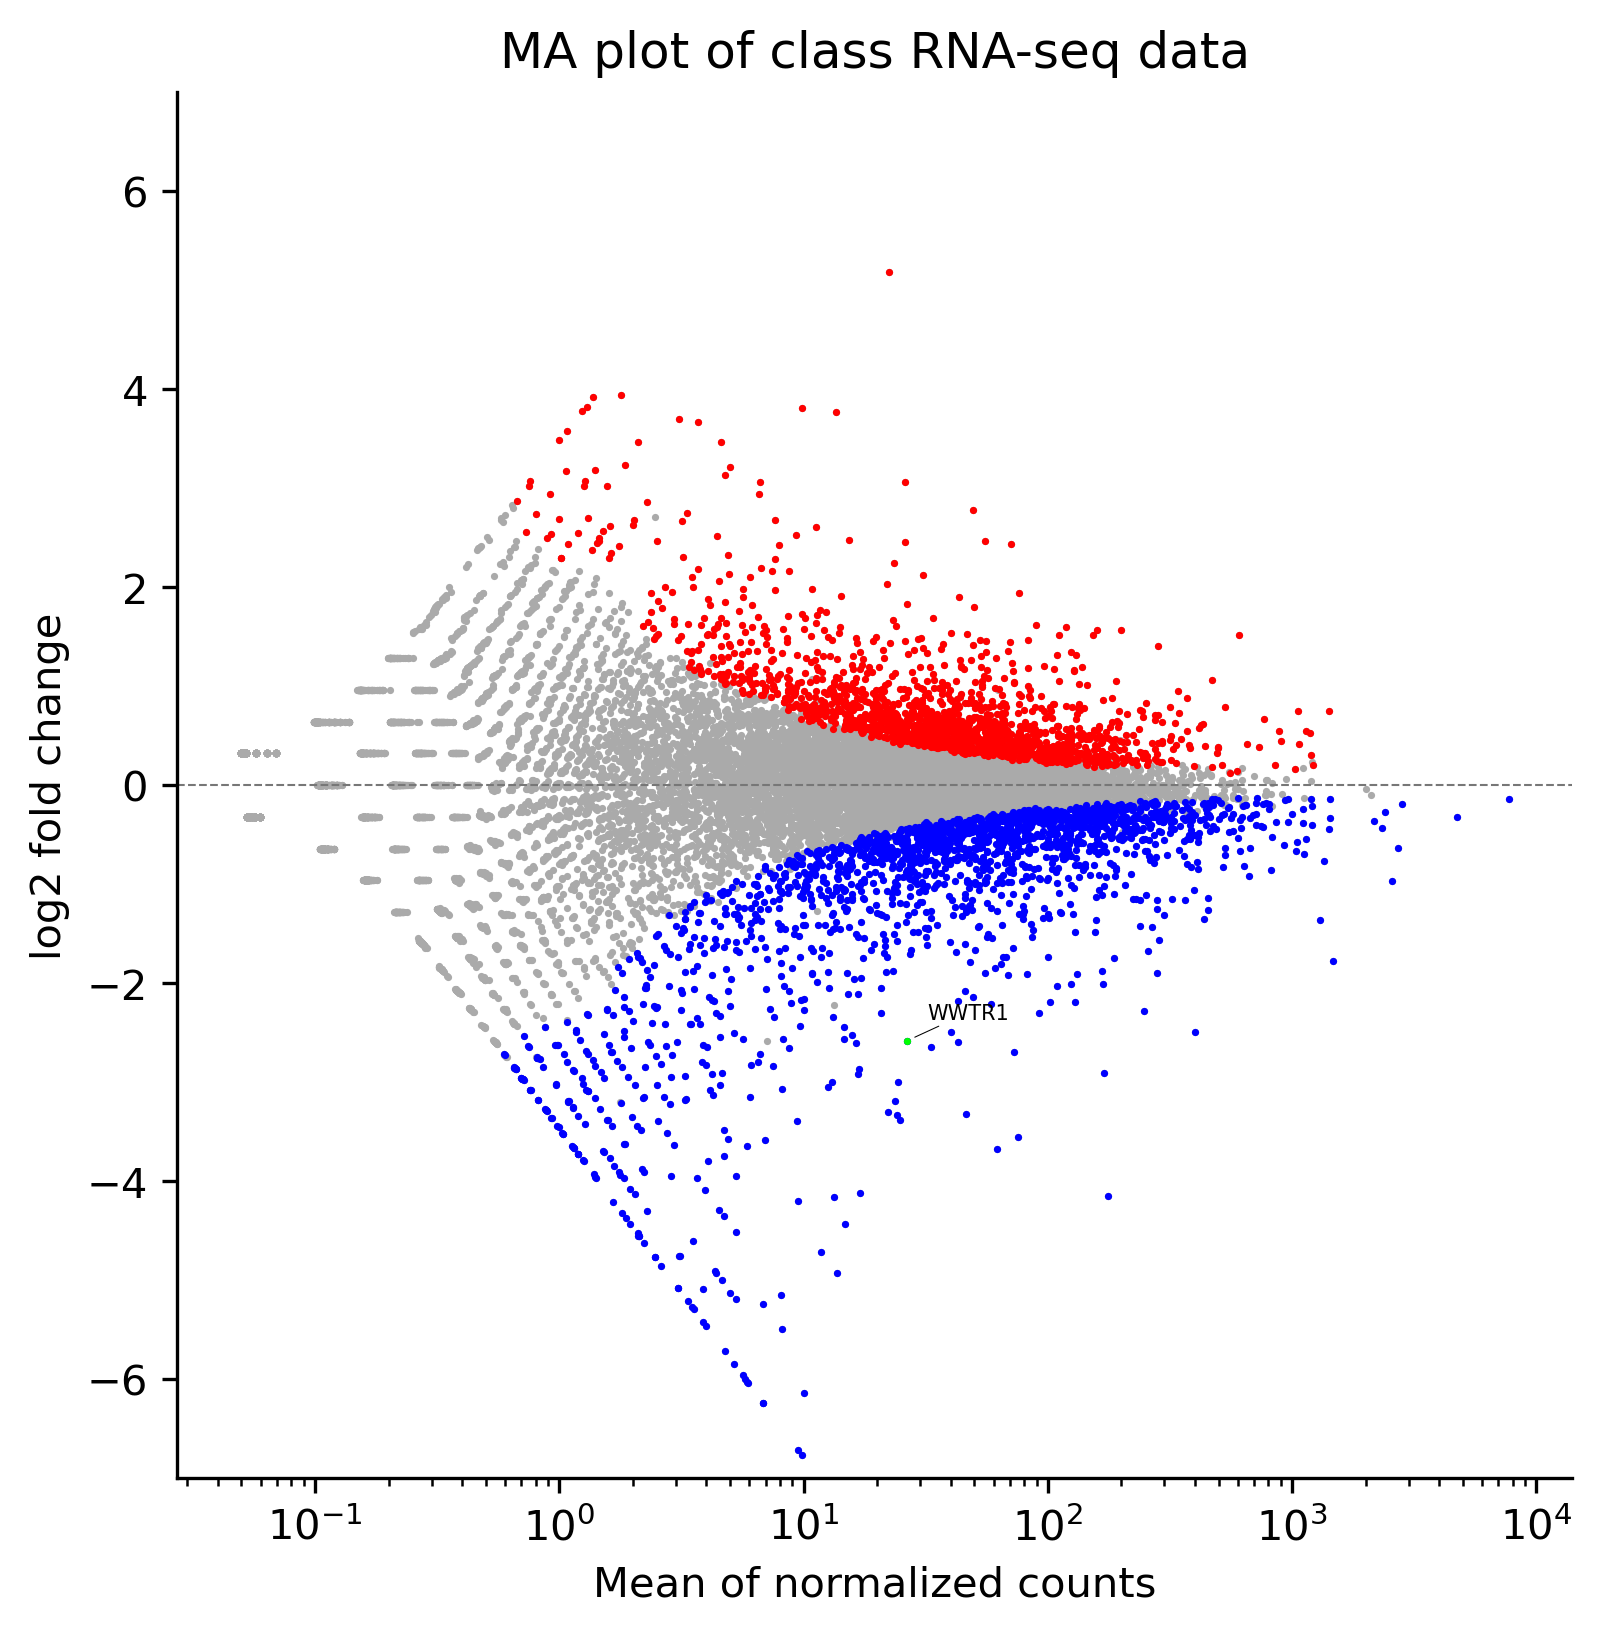

In [15]:
#Now let's set up our plot as usual
fig, ax = plt.subplots()

#Pull DataFrames for plotting into list
#Since we want to overlay them, we can just use a for loop to plot them all
results_list = [res, res_alpha_upreg, res_alpha_downreg, TAZ]
#Set up a list of colors we want to use for plotting
colors_to_use = ['#AAAAAA', '#FF0000', '#0000FF', '#00FF00']

#Now we run our for loop to plot
for i in range(0, len(results_list), 1):
    sns.scatterplot(x=results_list[i].baseMean,
                    y=results_list[i].log2FoldChange,
                    s=3,
                    c=colors_to_use[i],
                    lw=0
                   )

#With our data plotted, we can then pretty up our plot and add annotations
#This will set up a horizontal line at y-intercept of 0
plt.axhline(y=0,
            c='#777777',
            lw=0.5,
            ls='--',
           )

#Prepare a list containing text objects for annotation using adjust_text()
#This can be used as a different way to add annotations
#Particularly if you don't have exact information on positions
#Or are annotating a bunch of stuff (like we'll do in the volcano plot)
txt_annotation = [plt.text(TAZ.baseMean, TAZ.log2FoldChange, TAZ.gene.item(), fontsize=5)]

#Pretty up plot
ax.set_ylim(-7, 7)
ax.set_xscale('log')
ax.set_title('MA plot of class RNA-seq data')
ax.set_xlabel('Mean of normalized counts')
ax.set_ylabel('log2 fold change')

fig.set_dpi(300)
fig.set_size_inches(6, 6)
sns.despine()

#Based on documentation for adjust_text(), they recommend that we use it AFTER all plot setup is done
#So we run the function here rather than right after our txt_annotation variable is set
#Since it uses plot data to determine positions, which can end up changing when we pretty up our plot
adjustText.adjust_text(txt_annotation,
                       expand=(1.5, 3),
                       arrowprops={'arrowstyle' : '-',
                                   'linewidth' : 0.25
                                  },
                      )

#Save our figure to our week 10 folder
fig.savefig('../Week_10/differential-expression-analysis/1M_class_MA_plot.pdf',
            bbox_inches = 'tight',
           )

<h2>Plot MA plot of shrunken log2 fold change</h2>

For this, see what adjustments you'll need to make to your code from the previous MA plot to visualize the shrunken log2 fold change.

In [16]:
#Here we just run the same code but using our shrunken fold change results table instead
shrinklfc_alpha = shrinklfc.loc[shrinklfc.padj <= 0.05, :]
shrinklfc_alpha_upreg = shrinklfc_alpha.loc[shrinklfc_alpha.log2FoldChange > 0, :]
shrinklfc_alpha_downreg = shrinklfc_alpha.loc[shrinklfc_alpha.log2FoldChange < 0, :]
shrinklfc_TAZ = shrinklfc.loc[shrinklfc.gene == 'WWTR1', :]

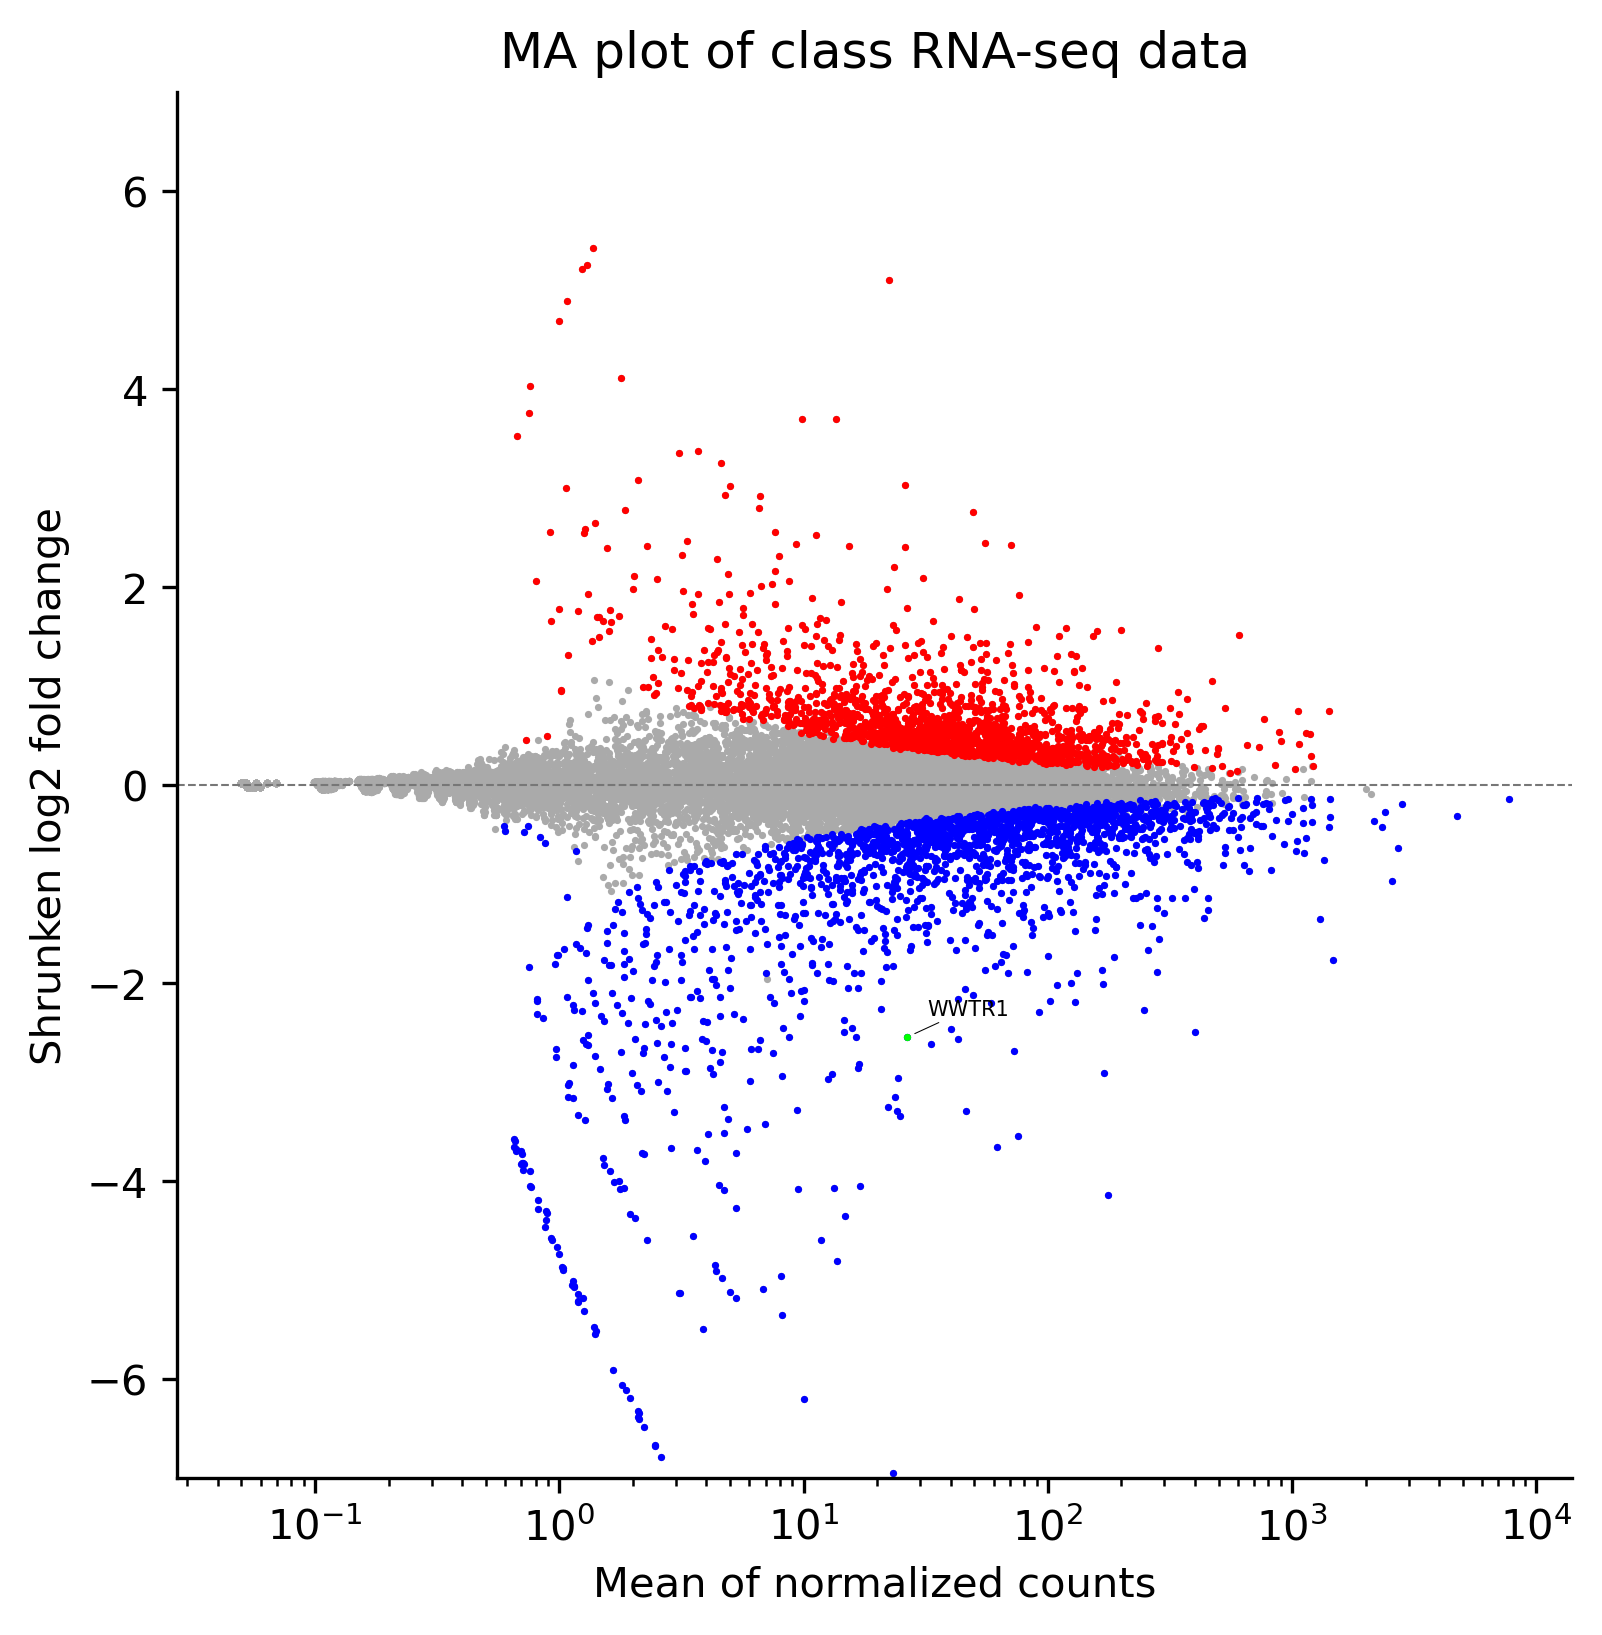

In [17]:
#Same here but now plotting using shrunken log fold change results
#Since the code is set up more flexibly, all we really need to do is update our results_list and our annotation
#and also the output file name
fig, ax = plt.subplots()

results_list = [shrinklfc, shrinklfc_alpha_upreg, shrinklfc_alpha_downreg, shrinklfc_TAZ]
colors_to_use = ['#AAAAAA', '#FF0000', '#0000FF', '#00FF00']

for i in range(0, len(results_list), 1):
    sns.scatterplot(x=results_list[i].baseMean,
                    y=results_list[i].log2FoldChange,
                    s=3,
                    c=colors_to_use[i],
                    lw=0
                   )

plt.axhline(y=0,
            c='#777777',
            lw=0.5,
            ls='--',
           )

txt_annotation = [plt.text(shrinklfc_TAZ.baseMean, 
                           shrinklfc_TAZ.log2FoldChange, 
                           shrinklfc_TAZ.gene.item(), 
                           fontsize=5)]

ax.set_ylim(-7, 7)
ax.set_xscale('log')
ax.set_title('MA plot of class RNA-seq data')
ax.set_xlabel('Mean of normalized counts')
ax.set_ylabel('Shrunken log2 fold change')

fig.set_dpi(300)
fig.set_size_inches(6, 6)
sns.despine()

adjustText.adjust_text(txt_annotation,
                       expand=(1.5, 3),
                       arrowprops={'arrowstyle' : '-',
                                   'linewidth' : 0.25
                                  },
                      )

fig.savefig('../Week_10/differential-expression-analysis/1M_class_MA_plot_shrunken.pdf',
            bbox_inches = 'tight',
           )

<h1 style="font-size: 40px; margin-bottom: 0px;">Exercise #2: Generate a volcano plot from your results</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 98%;"></hr>

Another plot that you'll commonly see with accompanying differential expression analyses is the volcano plot. In volcano plots, each gene's log2 fold change is plotted along the x-axis, and its -log10(padj) is plotted along the y-axis. The resulting scatterplot sort of resembles an erupting volcano with the most significant genes higher up along the y-axis, while genes that exhibit a greater log2 fold change are found further towards the negative and positive extremes of the x-axis.

For this exercise, take what you know from setting up your MA plots to now generate a volcano plot that includes the following:
<ul>
    <li>non-significant genes in gray</li>
    <li>upregulated genes highlighted in red</li>
    <li>downregulatd genes highlighted in blue</li>
    <li>dashed lines demarcating the following:</li>
    <ul>
        <li>a log2 fold change of -1</li>
        <li>a log2 fold change of +1</li>
        <li>a padj of 0.05</li>
    </ul>
    <li>Top 10 upregulated genes annotated based on their significance</li>
    <li>Top 10 downregulated genes annotated based on their significance</li>
</ul>

In [18]:
#Specify our threshold for what we consider "interesting"
#Here, we're separately pulling out upregulated and downregulated genes
#and our threshold is 2X difference or a log2FoldChange greater than or equal to 1
upreg = res_alpha.loc[res_alpha.log2FoldChange >= 1, :].copy()
downreg = res_alpha.loc[res_alpha.log2FoldChange <= -1, :].copy()

In [19]:
#Then we can pull out the top10 most significant genes based on their padj
top10_upreg = upreg.sort_values('padj').head(10)
top10_downreg = downreg.sort_values('padj').head(10)[1:]
F3 = downreg.loc[downreg.gene == 'F3', :]
#We have to separately pull out F3 because it has a padj of 0
#This is because the padj is soooooo small that it is beyond R's limit in how it represents numbers

In [20]:
F3

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
4303,F3,400.543384,-2.493562,0.064705,-38.537573,0.0,0.0


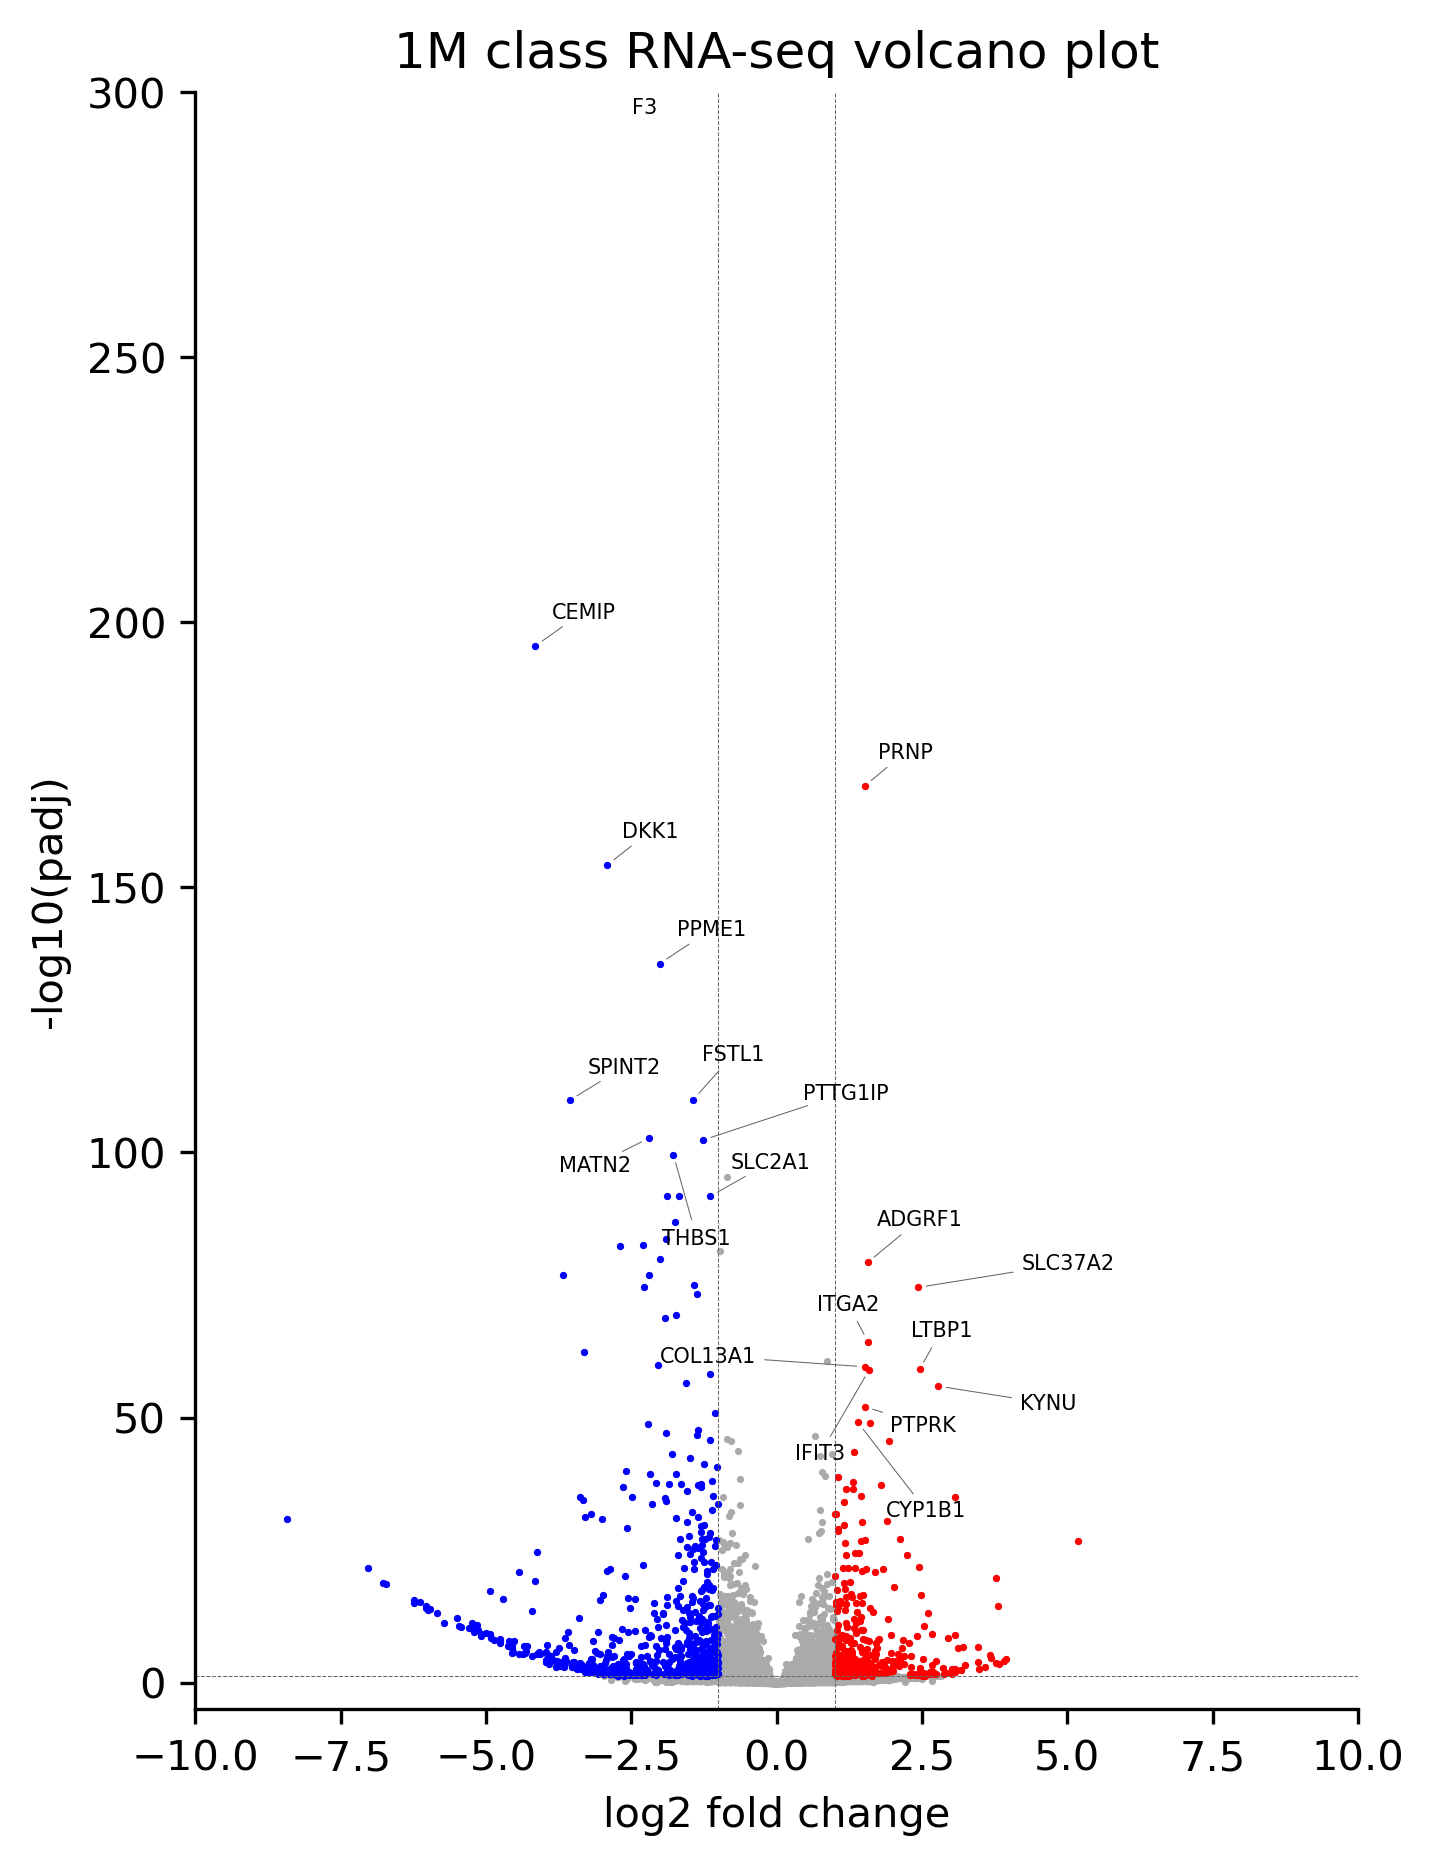

In [21]:
#Let's go ahead a plot our volcano plot
#We can make use of a similar set up as our MA plot
#But for our volcano plot, we're plotting different set of values on x and y axis compared to MA plot
fig, ax = plt.subplots()

results_list = [res, upreg, downreg]

for i in range(0, len(results_list), 1):
    sns.scatterplot(x=results_list[i].log2FoldChange,
                    y=np.log10(results_list[i].padj.pow(-1)),
                    s=3,
                    c=colors_to_use[i],
                    lw=0,
                   )


#Pretty up our plot
plt.axhline(y=np.log10(0.05**-1),
            c='#666666',
            lw=0.25,
            ls='--',
           )

plt.axvline(x=1,
            c='#666666',
            lw=0.25,
            ls='--',
           )

plt.axvline(x=-1,
            c='#666666',
            lw=0.25,
            ls='--',
           )

#Set up our text objects for annotation
#Here we're annotating the top10 most significant genes for both upregulated and downregulated sets
txt_up = [plt.text(x, np.log10(y), txt, fontsize=5) for x, y, txt in zip(top10_upreg.log2FoldChange, top10_upreg.padj**-1, top10_upreg.gene)]
txt_down = [plt.text(x, np.log10(y), txt, fontsize=5) for x, y, txt in zip(top10_downreg.log2FoldChange, top10_downreg.padj**-1, top10_downreg.gene)]

#We have to separately plot F3 because of the padj=0
#We'll run into a divide by zero error when -log10 transforming our padj
#So we can just plot it really high up for our plot
#R handles it similarly but without us having to explicitly do this ourselves
plt.text(F3.log2FoldChange, 296, F3.gene.item(), fontsize=5)

ax.set_ylim(-5, 300)
ax.set_xlim(-10, 10)
plt.title('1M class RNA-seq volcano plot')
plt.xlabel('log2 fold change')
plt.ylabel('-log10(padj)')

fig.set_dpi(300)
fig.set_size_inches(5, 7)
sns.despine()

adjustText.adjust_text(txt_up,
                       expand=(1.5, 3.5),
                       force_text=(2, 4),
                       arrowprops={'arrowstyle' : '-',
                                   'linewidth' : 0.25,
                                   'color' : '#666666'
                                  },
                      )

adjustText.adjust_text(txt_down,
                       expand=(1.5, 3.5),
                       force_text=(2, 4),
                       arrowprops={'arrowstyle' : '-',
                                   'linewidth' : 0.25,
                                   'color' : '#666666'
                                  },
                      )

fig.savefig('../Week_10/differential-expression-analysis/1M_class_volcano_plot.pdf',
            bbox_inches = 'tight',
           )

<h1 style="font-size: 40px; margin-bottom: 0px;">Violin plots and box-and-whisker plots</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 98%;"></hr>

Another way that you can visualize your RNA-seq data is to generate violin plots or box-and-whisker plots for individual genes (or sets of genes) using the normalized counts. The set up for either one is the same since they are essentially different ways of visualizing the distribution of your samples.

For plotting violin plots, we'll make use of <code>sns.violinplot()</code>. <a href="https://seaborn.pydata.org/generated/seaborn.violinplot.html" rel="noopener noreferrer"><u>Documentation for <code>sns.violinplot()</code> can be found here.</u></a>

And to plot a box-and-whisker plot, we'll make use of <code>sns.boxplot()</code>. <a href="https://seaborn.pydata.org/generated/seaborn.boxplot.html" rel="noopener noreferrer"><u>Documentation for <code>sns.boxplot()</code> can be found here.</u></a>

For this guided exercise, we can continue to make use of the genes that were identified to be differentially expressed that we labeled in our volcano plot and use them to pull out the associated normalized counts. First we can do this for our top ten significantly upregulated genes (based on their <code>'padj'</code>).

In [22]:
top10_upreg

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
11254,PRNP,607.601777,1.517942,0.054054,28.082143,1.618765e-173,7.344338e-170
260,ADGRF1,158.725037,1.566567,0.081269,19.276318,8.490993e-83,5.503377e-80
13511,SLC37A2,70.621899,2.436624,0.130325,18.696550,5.281352e-78,2.764788e-75
6401,ITGA2,199.873167,1.571279,0.090397,17.381898,1.131462e-67,5.133445e-65
2722,COL13A1,111.258379,1.519757,0.090779,16.741212,6.563820e-63,2.627652e-60
8157,LTBP1,55.533262,2.460823,0.147600,16.672275,2.085064e-62,8.108515e-60
6109,IFIT3,118.539360,1.594576,0.095692,16.663633,2.409330e-62,9.109274e-60
6849,KYNU,49.222515,2.775069,0.171023,16.226281,3.287856e-59,1.147462e-56
11512,PTPRK,152.546939,1.517467,0.096874,15.664356,2.651002e-55,9.020699e-53
3123,CYP1B1,281.864089,1.399749,0.091966,15.220292,2.593691e-52,8.405411e-50


In [23]:
#We can use the pd.Series.isin() to pull out just our top10 upregulated genes
#pd.Series.isin() returns a bool output, so we can treat it like our other conditional statements to filter our normalized counts table
norm_counts_upreg = norm_counts.loc[norm_counts.gene.isin(top10_upreg.gene), :]

Let's take a look at the new filtered DataFrame.

In [24]:
norm_counts_upreg.style

,gene,ctrl_g1,tazko_g1,ctrl_g2,tazko_g2,ctrl_g3,tazko_g3,ctrl_g4,tazko_g4,ctrl_g5,tazko_g5,ctrl_g6,tazko_g6,ctrl_g7,tazko_g7,ctrl_g8,tazko_g8,ctrl_g9,tazko_g9
260,ADGRF1,67.537234,238.246057,84.236733,248.192616,78.613888,258.996046,79.549283,224.115385,74.813010,193.929155,93.061711,225.421387,81.157490,251.224579,76.510923,239.177300,86.093573,256.174305
2722,COL13A1,60.584872,170.175755,56.157822,177.280440,55.882161,175.045604,72.410245,159.288621,57.548469,159.097219,51.807551,158.168597,57.969636,162.610819,41.645186,173.197355,64.570180,149.210297
3123,CYP1B1,168.843085,350.665192,181.060564,396.879436,117.447254,485.840859,149.919802,437.117610,155.380867,316.311631,128.559478,403.516736,146.856411,453.117787,160.769787,369.304414,187.253521,464.709177
6109,IFIT3,58.598482,162.956178,42.602486,179.567929,71.983801,154.504538,66.291069,201.889066,65.221598,200.518980,59.482743,164.395707,64.732760,168.092082,52.298605,179.612072,49.503804,191.456586
6401,ITGA2,89.387515,298.065413,91.982639,338.548453,131.654583,328.657052,75.469832,313.020661,101.668962,249.471971,99.777505,317.582617,86.954454,290.506968,105.565703,252.006734,122.683341,304.712594
6849,KYNU,4.965973,79.415352,10.650621,105.224519,10.418708,77.698814,10.198626,89.831373,6.713988,82.843522,21.106780,69.743633,13.526248,96.835656,20.338347,80.642155,15.066375,90.784578
8157,LTBP1,15.891114,80.446721,24.205958,106.368264,13.260174,94.667520,10.198626,92.609663,17.264541,80.019311,16.309784,109.597138,20.289373,94.095024,16.464376,82.474931,19.371054,106.065151
11254,PRNP,319.808666,809.624047,329.201026,889.833434,318.244173,943.995934,297.799879,918.687858,318.434863,814.314169,291.657322,865.568308,340.088530,892.532415,298.295749,934.715887,318.546219,1035.483505
11512,PTPRK,87.401126,212.461852,74.554350,250.480105,87.138285,268.820034,53.032855,225.041481,86.322704,171.335467,94.021110,234.139341,75.360527,226.558893,73.605444,202.521775,78.560385,244.489161
13511,SLC37A2,13.904725,128.921027,22.269481,105.224519,22.731727,134.856562,19.377389,121.318659,23.978529,107.320018,17.269184,117.069670,20.289373,114.192991,35.834230,117.297680,22.599563,126.738867


Much like how DESeq2 required a conditions matrix to understand which condition each sample belonged to, we'll swap out our column headers with the information from our conditions matrix. That way, we can specify how we want to group our data later on based on which condition each sample belongs to. 

In [25]:
norm_counts_upreg.columns = ['gene'] + conditions.condition.to_list()

In [26]:
norm_counts_upreg

,gene,control,tazko,control,tazko,control,tazko,control,tazko,control,tazko,control,tazko,control,tazko,control,tazko,control,tazko
260,ADGRF1,67.537234,238.246057,84.236733,248.192616,78.613888,258.996046,79.549283,224.115385,74.813010,193.929155,93.061711,225.421387,81.157490,251.224579,76.510923,239.177300,86.093573,256.174305
2722,COL13A1,60.584872,170.175755,56.157822,177.280440,55.882161,175.045604,72.410245,159.288621,57.548469,159.097219,51.807551,158.168597,57.969636,162.610819,41.645186,173.197355,64.570180,149.210297
3123,CYP1B1,168.843085,350.665192,181.060564,396.879436,117.447254,485.840859,149.919802,437.117610,155.380867,316.311631,128.559478,403.516736,146.856411,453.117787,160.769787,369.304414,187.253521,464.709177
6109,IFIT3,58.598482,162.956178,42.602486,179.567929,71.983801,154.504538,66.291069,201.889066,65.221598,200.518980,59.482743,164.395707,64.732760,168.092082,52.298605,179.612072,49.503804,191.456586
6401,ITGA2,89.387515,298.065413,91.982639,338.548453,131.654583,328.657052,75.469832,313.020661,101.668962,249.471971,99.777505,317.582617,86.954454,290.506968,105.565703,252.006734,122.683341,304.712594
6849,KYNU,4.965973,79.415352,10.650621,105.224519,10.418708,77.698814,10.198626,89.831373,6.713988,82.843522,21.106780,69.743633,13.526248,96.835656,20.338347,80.642155,15.066375,90.784578
8157,LTBP1,15.891114,80.446721,24.205958,106.368264,13.260174,94.667520,10.198626,92.609663,17.264541,80.019311,16.309784,109.597138,20.289373,94.095024,16.464376,82.474931,19.371054,106.065151
11254,PRNP,319.808666,809.624047,329.201026,889.833434,318.244173,943.995934,297.799879,918.687858,318.434863,814.314169,291.657322,865.568308,340.088530,892.532415,298.295749,934.715887,318.546219,1035.483505
11512,PTPRK,87.401126,212.461852,74.554350,250.480105,87.138285,268.820034,53.032855,225.041481,86.322704,171.335467,94.021110,234.139341,75.360527,226.558893,73.605444,202.521775,78.560385,244.489161
13511,SLC37A2,13.904725,128.921027,22.269481,105.224519,22.731727,134.856562,19.377389,121.318659,23.978529,107.320018,17.269184,117.069670,20.289373,114.192991,35.834230,117.297680,22.599563,126.738867


We can then move our gene names and use them as an index. That way, when we transpose our DataFrame, the gene names will become the column headers.

In [27]:
norm_counts_upreg.set_index('gene', inplace=True)

In [28]:
norm_counts_upreg

,control,tazko,control,tazko,control,tazko,control,tazko,control,tazko,control,tazko,control,tazko,control,tazko,control,tazko
gene,,,,,,,,,,,,,,,,,,
ADGRF1,67.537234,238.246057,84.236733,248.192616,78.613888,258.996046,79.549283,224.115385,74.813010,193.929155,93.061711,225.421387,81.157490,251.224579,76.510923,239.177300,86.093573,256.174305
COL13A1,60.584872,170.175755,56.157822,177.280440,55.882161,175.045604,72.410245,159.288621,57.548469,159.097219,51.807551,158.168597,57.969636,162.610819,41.645186,173.197355,64.570180,149.210297
CYP1B1,168.843085,350.665192,181.060564,396.879436,117.447254,485.840859,149.919802,437.117610,155.380867,316.311631,128.559478,403.516736,146.856411,453.117787,160.769787,369.304414,187.253521,464.709177
IFIT3,58.598482,162.956178,42.602486,179.567929,71.983801,154.504538,66.291069,201.889066,65.221598,200.518980,59.482743,164.395707,64.732760,168.092082,52.298605,179.612072,49.503804,191.456586
ITGA2,89.387515,298.065413,91.982639,338.548453,131.654583,328.657052,75.469832,313.020661,101.668962,249.471971,99.777505,317.582617,86.954454,290.506968,105.565703,252.006734,122.683341,304.712594
KYNU,4.965973,79.415352,10.650621,105.224519,10.418708,77.698814,10.198626,89.831373,6.713988,82.843522,21.106780,69.743633,13.526248,96.835656,20.338347,80.642155,15.066375,90.784578
LTBP1,15.891114,80.446721,24.205958,106.368264,13.260174,94.667520,10.198626,92.609663,17.264541,80.019311,16.309784,109.597138,20.289373,94.095024,16.464376,82.474931,19.371054,106.065151
PRNP,319.808666,809.624047,329.201026,889.833434,318.244173,943.995934,297.799879,918.687858,318.434863,814.314169,291.657322,865.568308,340.088530,892.532415,298.295749,934.715887,318.546219,1035.483505
PTPRK,87.401126,212.461852,74.554350,250.480105,87.138285,268.820034,53.032855,225.041481,86.322704,171.335467,94.021110,234.139341,75.360527,226.558893,73.605444,202.521775,78.560385,244.489161


Now let's transpose our DataFrame.

In [29]:
norm_counts_upreg = norm_counts_upreg.T

Now let's take another look at our data:

In [30]:
norm_counts_upreg

gene,ADGRF1,COL13A1,CYP1B1,IFIT3,ITGA2,KYNU,LTBP1,PRNP,PTPRK,SLC37A2
control,67.537234,60.584872,168.843085,58.598482,89.387515,4.965973,15.891114,319.808666,87.401126,13.904725
tazko,238.246057,170.175755,350.665192,162.956178,298.065413,79.415352,80.446721,809.624047,212.461852,128.921027
control,84.236733,56.157822,181.060564,42.602486,91.982639,10.650621,24.205958,329.201026,74.554350,22.269481
tazko,248.192616,177.280440,396.879436,179.567929,338.548453,105.224519,106.368264,889.833434,250.480105,105.224519
control,78.613888,55.882161,117.447254,71.983801,131.654583,10.418708,13.260174,318.244173,87.138285,22.731727
tazko,258.996046,175.045604,485.840859,154.504538,328.657052,77.698814,94.667520,943.995934,268.820034,134.856562
control,79.549283,72.410245,149.919802,66.291069,75.469832,10.198626,10.198626,297.799879,53.032855,19.377389
tazko,224.115385,159.288621,437.117610,201.889066,313.020661,89.831373,92.609663,918.687858,225.041481,121.318659
control,74.813010,57.548469,155.380867,65.221598,101.668962,6.713988,17.264541,318.434863,86.322704,23.978529
tazko,193.929155,159.097219,316.311631,200.518980,249.471971,82.843522,80.019311,814.314169,171.335467,107.320018


<h2>Plot a violin plot for a single gene</h2>

Now let's set up a violin plot to take a look at a single gene first by identifying what our X-axis will be and what our Y-axis will be. Then we can begin adding additional parameters to modify the plot, and then call up specific plot attributes to pretty things up.

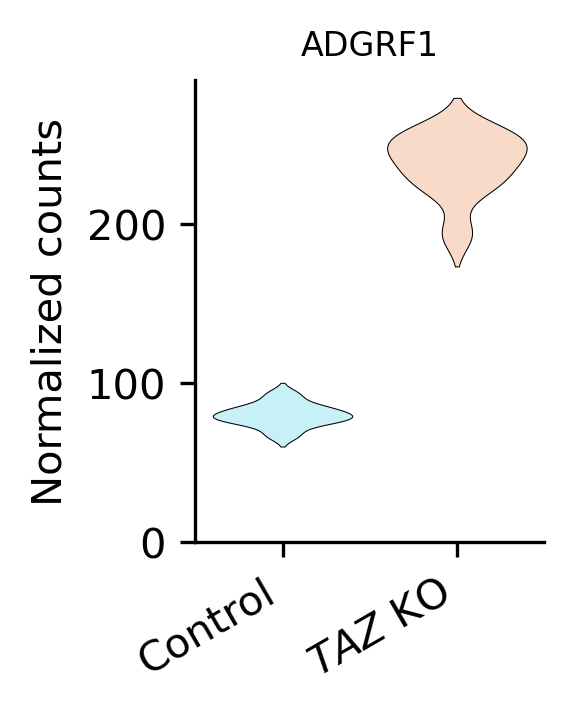

In [31]:
#Pick two colors to differentiate between conditions
#When we set a hue based on condition, it'll separate the groups and color them according to our color set
color_set = ['#C0F6FF', '#FFD9C0']

#Set up our figure as usual
fig, ax = plt.subplots()

#Now, we can set up our violin plot
sns.violinplot(x=norm_counts_upreg.index,      #We want our x-axis to based on condition
               y=norm_counts_upreg.ADGRF1,     #We plot our counts for ADGRF1 gene
               hue=norm_counts_upreg.index,    #And we separate the control from tazko using hue parameter
               palette=color_set,              #Then we can color the conditions based on our color set
               inner=None,                     #Removes the default box-whisker plot
               bw_method=0.5,                  #Sets estimation method
               density_norm='width',           #normalizes violin plots based on max width
               linewidth=0.25,                 #Stylizing
               linecolor='k',                  #Stylizing
              )

#Pretty up our plots
ax.set_xlabel(None)
ax.set_ylabel('Normalized counts')
ax.set_title('ADGRF1',
             fontsize=8,
            )
ax.set_xticks([0,1], 
              ['Control', '$TAZ$ KO'],
              rotation=30,
              ha='right',
             )
plt.ylim(0)

sns.despine()
fig.set_dpi(300)
fig.set_size_inches(1.5, 2)
plt.show()


<h2>Plot a box-and-whisker plot for a single gene</h2>

We can take our code for the violin plot and make modifications to the arguments that we pass to the <code>sns.boxplot()</code> function:

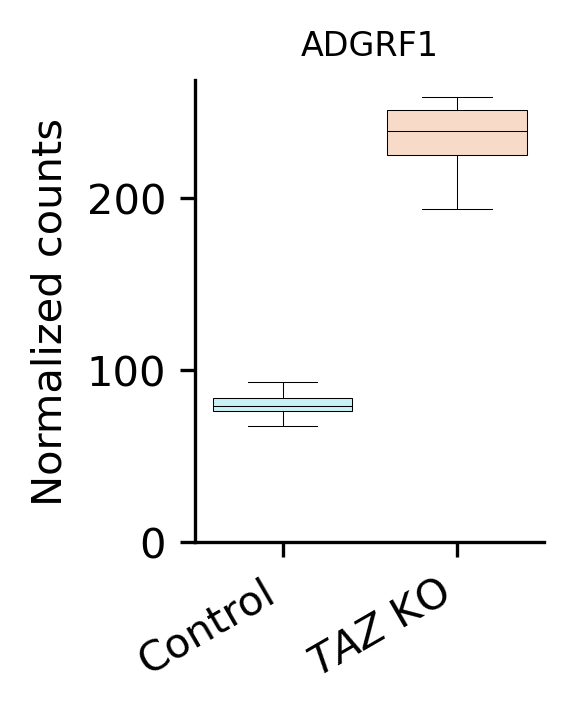

In [32]:
#We can simply modify our violin plot code swapping out violin-plot specific parameters for boxplot ones
color_set = ['#C0F6FF', '#FFD9C0']

fig, ax = plt.subplots()

sns.boxplot(x=norm_counts_upreg.index,
            y=norm_counts_upreg.ADGRF1,
            hue=norm_counts_upreg.index,
            palette=color_set,
            linewidth=0.25,
            linecolor='k',
           )

ax.set_xlabel(None)
ax.set_ylabel('Normalized counts')
ax.set_title('ADGRF1',
             fontsize=8,
            )
ax.set_xticks([0,1], 
              ['Control', '$TAZ$ KO'],
              rotation=30,
              ha='right',
             )
plt.ylim(0)

sns.despine()
fig.set_dpi(300)
fig.set_size_inches(1.5, 2)
plt.show()

<h2>Swarmplot for individual genes</h2>

Like with our earlier notebooks, we can also plot our data as a swarmplot with overlaid annotations.

In [33]:
#We reset our index here to make plotting slightly easier later
norm_counts_upreg.reset_index(inplace=True, names=['condition'])

In [34]:
norm_counts_upreg

gene,condition,ADGRF1,COL13A1,CYP1B1,IFIT3,ITGA2,KYNU,LTBP1,PRNP,PTPRK,SLC37A2
0,control,67.537234,60.584872,168.843085,58.598482,89.387515,4.965973,15.891114,319.808666,87.401126,13.904725
1,tazko,238.246057,170.175755,350.665192,162.956178,298.065413,79.415352,80.446721,809.624047,212.461852,128.921027
2,control,84.236733,56.157822,181.060564,42.602486,91.982639,10.650621,24.205958,329.201026,74.554350,22.269481
3,tazko,248.192616,177.280440,396.879436,179.567929,338.548453,105.224519,106.368264,889.833434,250.480105,105.224519
4,control,78.613888,55.882161,117.447254,71.983801,131.654583,10.418708,13.260174,318.244173,87.138285,22.731727
5,tazko,258.996046,175.045604,485.840859,154.504538,328.657052,77.698814,94.667520,943.995934,268.820034,134.856562
6,control,79.549283,72.410245,149.919802,66.291069,75.469832,10.198626,10.198626,297.799879,53.032855,19.377389
7,tazko,224.115385,159.288621,437.117610,201.889066,313.020661,89.831373,92.609663,918.687858,225.041481,121.318659
8,control,74.813010,57.548469,155.380867,65.221598,101.668962,6.713988,17.264541,318.434863,86.322704,23.978529
9,tazko,193.929155,159.097219,316.311631,200.518980,249.471971,82.843522,80.019311,814.314169,171.335467,107.320018


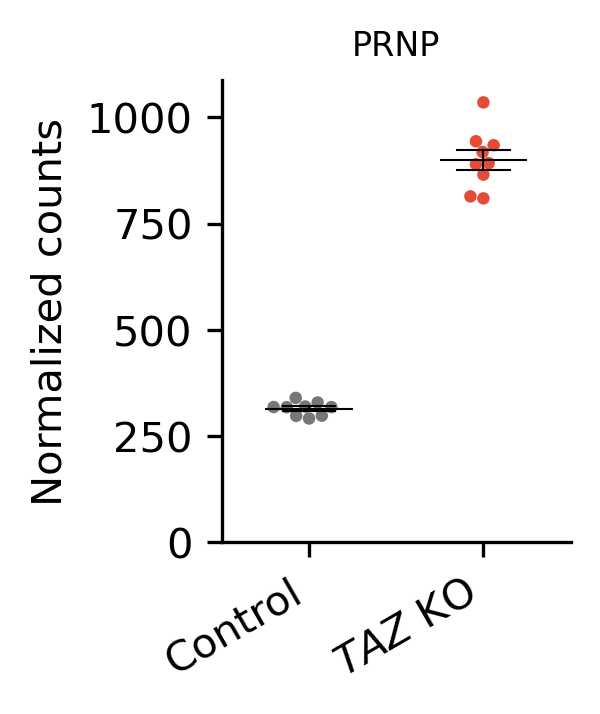

In [35]:
#Now we can pull our swarmplot annotation code to plot our normalized counts data for a gene of interest
#Refer back to our statistical analysis notebooks (week 2) to refresh yourself on the swarmplot annotation setup
color_set = ['#777777', '#E64B35']
#We can make it a little easier to quickly try out different genes by assigning the gene name to a variable used throughout the code
gene_to_see = 'PRNP'

fig, ax = plt.subplots()

sns.swarmplot(data=norm_counts_upreg,
              x='condition',
              y=gene_to_see,
              hue='condition',
              palette=color_set,
              s=3,
              zorder=0
             )

sns.barplot(data=norm_counts_upreg,
            x='condition',
            y=gene_to_see,
            hue='condition',
            estimator=np.mean,
            alpha=0,
            errorbar='se',
            capsize=0.3,
            err_kws={'linewidth' : 0.5,
                     'color': 'k'
                    },
           )

sns.boxplot(data=norm_counts_upreg,
            x='condition',
            y=gene_to_see,
            hue='condition',
            showmeans=True,
            meanline=True,
            width=0.5,
            meanprops={'color' : 'k',
                       'linestyle' : '-',
                       'linewidth' : 0.5
                      },
            medianprops={'visible' : False},
            whiskerprops={'visible' : False},
            showfliers=False,
            showbox=False,
            showcaps=False,
           )

ax.set_xlabel(None)
ax.set_ylabel('Normalized counts')
ax.set_title(gene_to_see, 
             fontsize=8,
            )
ax.set_xticks([0,1], 
              ['Control', '$TAZ$ KO'],
              rotation=30,
              ha='right',
             )
plt.ylim(0)

sns.despine()
fig.set_dpi(300)
fig.set_size_inches(1.5, 2)

plt.show()


<h2>Set up to plot multiple gene(s) on a single plot</h2>

The set up to plot multiple genes on a single violin plot or box-and-whisker plot is slightly different than plotting a single gene. Whereas the "wide-format" of our original DataFrame allows us to distinguish between the conditions of each gene, if we want to plot multiple genes, we'll also need to distinguish between genes as well. One way to do this is to convert the "wide-format" DataFrame into a "long-format" DataFrame, where all the normalized count values are contained within a single, long column, and the associated information on which condition (either control or TAZ KO) and which gene it comes from are located in their own respective columns. So with this format, each row corresponds to a single normalized count value and its "metadata".

<table style="text-align: center; margin: auto;">
    <tr>
        <th style="border: none">&nbsp;</th>
        <th style="border: 1px solid; border-color: #000000;">condition</th>
        <th style="border: 1px solid; border-color: #000000;">count</th>
        <th style="border: 1px solid; border-color: #000000;">gene</th>
    </tr>
    <tr>
        <th style="border: 1px solid; border-color: #000000;">0</th>
        <td style="border: 1px solid; border-color: #000000;">control</td>
        <td style="border: 1px solid; border-color: #000000;">100.000</td>
        <td style="border: 1px solid; border-color: #000000;">first_gene</td>
    </tr>
    <tr>
        <th style="border: 1px solid; border-color: #000000;">1</th>
        <td style="border: 1px solid; border-color: #000000;">tazko</td>
        <td style="border: 1px solid; border-color: #000000;">200.000</td>
        <td style="border: 1px solid; border-color: #000000;">first_gene</td>
    </tr>
    <tr>
        <th style="border: 1px solid; border-color: #000000;">2</th>
        <td style="border: 1px solid; border-color: #000000;">control</td>
        <td style="border: 1px solid; border-color: #000000;">150.000</td>
        <td style="border: 1px solid; border-color: #000000;">first_gene</td>
    </tr>
    <tr>
        <th style="border: 1px solid; border-color: #000000;">3</th>
        <td style="border: 1px solid; border-color: #000000;">tazko</td>
        <td style="border: 1px solid; border-color: #000000;">300.000</td>
        <td style="border: 1px solid; border-color: #000000;">first_gene</td>
    </tr>
    <tr>
        <th style="border: 1px solid; border-color: #000000;">4</th>
        <td style="border: 1px solid; border-color: #000000;">control</td>
        <td style="border: 1px solid; border-color: #000000;">400.000</td>
        <td style="border: 1px solid; border-color: #000000;">second_gene</td>
    </tr>
    <tr>
        <th style="border: 1px solid; border-color: #000000;">5</th>
        <td style="border: 1px solid; border-color: #000000;">tazko</td>
        <td style="border: 1px solid; border-color: #000000;">900.000</td>
        <td style="border: 1px solid; border-color: #000000;">second_gene</td>
    </tr>
    <tr>
        <th style="border: 1px solid; border-color: #000000;">6</th>
        <td style="border: 1px solid; border-color: #000000;">control</td>
        <td style="border: 1px solid; border-color: #000000;">300.000</td>
        <td style="border: 1px solid; border-color: #000000;">second_gene</td>
    </tr>
    <tr>
        <th style="border: 1px solid; border-color: #000000;">7</th>
        <td style="border: 1px solid; border-color: #000000;">tazko</td>
        <td style="border: 1px solid; border-color: #000000;">600.000</td>
        <td style="border: 1px solid; border-color: #000000;">second_gene</td>
    </tr>
    <tr>
        <th style="border: 1px solid; border-color: #000000;">...</th>
        <td style="border: 1px solid; border-color: #000000;">...</td>
        <td style="border: 1px solid; border-color: #000000;">...</td>
        <td style="border: 1px solid; border-color: #000000;">...</td>
    </tr>
    <tr>
        <th style="border: 1px solid; border-color: #000000;">96</th>
        <td style="border: 1px solid; border-color: #000000;">control</td>
        <td style="border: 1px solid; border-color: #000000;">50.000</td>
        <td style="border: 1px solid; border-color: #000000;">last_gene</td>
    </tr>
    <tr>
        <th style="border: 1px solid; border-color: #000000;">97</th>
        <td style="border: 1px solid; border-color: #000000;">tazko</td>
        <td style="border: 1px solid; border-color: #000000;">70.000</td>
        <td style="border: 1px solid; border-color: #000000;">last_gene</td>
    </tr>
    <tr>
        <th style="border: 1px solid; border-color: #000000;">98</th>
        <td style="border: 1px solid; border-color: #000000;">control</td>
        <td style="border: 1px solid; border-color: #000000;">20.000</td>
        <td style="border: 1px solid; border-color: #000000;">last_gene</td>
    </tr>
    <tr>
        <th style="border: 1px solid; border-color: #000000;">99</th>
        <td style="border: 1px solid; border-color: #000000;">tazko</td>
        <td style="border: 1px solid; border-color: #000000;">30.000</td>
        <td style="border: 1px solid; border-color: #000000;">last_gene</td>
    </tr>
</table>

This can kind of be thought of as flattening or melting our DataFrame, since we're collapsing our 2D normalized count matrix into a single column, and the other columns can be thought of as extra information on where the values came from, so that we can distinguish between genes and conditions.

First, let's take a look again at our normalized counts, and for this example, we're interested in taking a look at just our top upregulated genes.

In [36]:
#We have our wide format table
norm_counts_upreg

#Note how the column headers are genes and the column values are the counts for different conditions noted in the condition column
#We can pivot this table so that all the counts values become collapsed into a single column
#And the information column header and condition column are all maintained/associated to each respective count

gene,condition,ADGRF1,COL13A1,CYP1B1,IFIT3,ITGA2,KYNU,LTBP1,PRNP,PTPRK,SLC37A2
0,control,67.537234,60.584872,168.843085,58.598482,89.387515,4.965973,15.891114,319.808666,87.401126,13.904725
1,tazko,238.246057,170.175755,350.665192,162.956178,298.065413,79.415352,80.446721,809.624047,212.461852,128.921027
2,control,84.236733,56.157822,181.060564,42.602486,91.982639,10.650621,24.205958,329.201026,74.554350,22.269481
3,tazko,248.192616,177.280440,396.879436,179.567929,338.548453,105.224519,106.368264,889.833434,250.480105,105.224519
4,control,78.613888,55.882161,117.447254,71.983801,131.654583,10.418708,13.260174,318.244173,87.138285,22.731727
5,tazko,258.996046,175.045604,485.840859,154.504538,328.657052,77.698814,94.667520,943.995934,268.820034,134.856562
6,control,79.549283,72.410245,149.919802,66.291069,75.469832,10.198626,10.198626,297.799879,53.032855,19.377389
7,tazko,224.115385,159.288621,437.117610,201.889066,313.020661,89.831373,92.609663,918.687858,225.041481,121.318659
8,control,74.813010,57.548469,155.380867,65.221598,101.668962,6.713988,17.264541,318.434863,86.322704,23.978529
9,tazko,193.929155,159.097219,316.311631,200.518980,249.471971,82.843522,80.019311,814.314169,171.335467,107.320018


To flatten our DataFrame, we can make use of the function <code>pd.melt()</code> which will allow us to convert the format of our DataFrame from a "wide-format" to a "long-format".

<a href="https://pandas.pydata.org/docs/reference/api/pandas.melt.html" rel="noopener noreferrer"><u>Documentation for <code>pd.melt()</code> is here.</u></a>

In [37]:
#We can pivot using the pd.melt() function to go from wide to long format table
long_df_upreg = pd.melt(norm_counts_upreg,                           #We provide our wide format table
                        id_vars='condition',                         #We specify what we're pivoting on
                        value_vars=norm_counts_upreg.columns[1:],    #We collapse our counts into a single column maintaining their associated gene (& also condition)
                        value_name='count',                          #We then name that column 'count'
                       )

#This is mostly to make plotting multiple genes at once easier, so we only need to make small modifications to our earlier code

In [38]:
#Sanity check
long_df_upreg.head().style

,condition,gene,count
0,control,ADGRF1,67.537234
1,tazko,ADGRF1,238.246057
2,control,ADGRF1,84.236733
3,tazko,ADGRF1,248.192616
4,control,ADGRF1,78.613888


<h2>Plot violin plot for upregulated genes</h2>

We can make use of the same code that we used before to plot a violin plot for one gene with slight modifications to have it plot multiple genes together on a single plot.

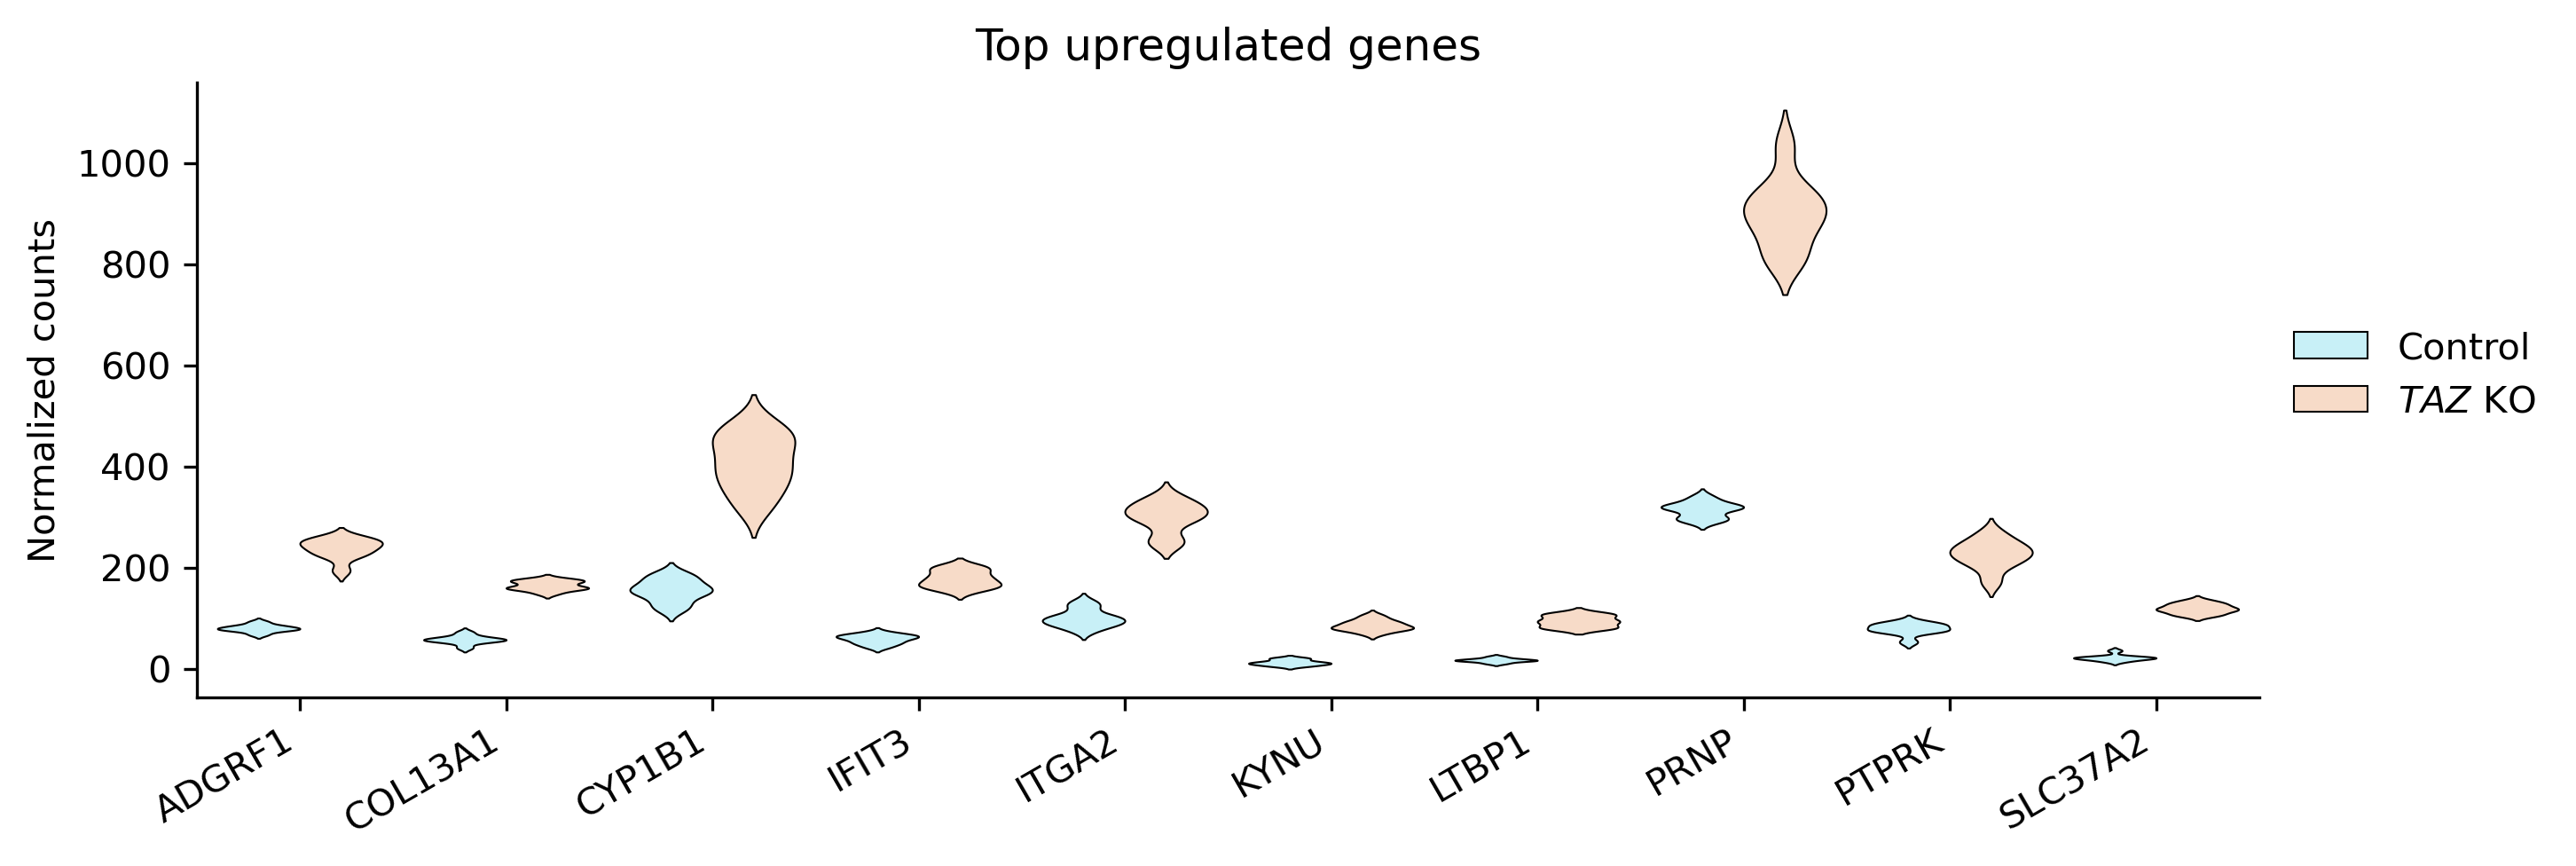

In [44]:
#Let's take the long format table now and modify our earlier code to plot multiple genes at once
#So we can see all the top10 together
color_set = ['#C0F6FF', '#FFD9C0']
fig, ax = plt.subplots()

#The way we'll call up our data is now slightly different
sns.violinplot(data=long_df_upreg,          #We provide our long format table
               x='gene',                    #Then we specify we want our data arranged by gene along x-axis
               y='count',                   #And the counts plotted along y-axis
               hue='condition',             #We separate by condition
               inner=None,
               bw_method=0.5,
               density_norm='width',
               palette=color_set,
               linewidth=0.5,
               linecolor='k',
              )

#We also have to pull out information to update our legends a little bit differently
#instead of just straight calling up our legend since there's also extra bits in the legend that we don't care about
handles, labels = ax.get_legend_handles_labels()
labels = ['Control', '$TAZ$ KO']

plt.legend(handles,
           labels,
           bbox_to_anchor=(1.15, 0.25, 0, 0.4),
           edgecolor='None',
          )

ax.set_xlabel(None)
ax.set_ylabel('Normalized counts')
ax.set_title('Top upregulated genes')
plt.xticks(rotation=30,
           ha='right',
          )

sns.despine()
fig.set_dpi(300)
fig.set_size_inches(10, 3)
plt.show()

fig.savefig('../Week_10/differential-expression-analysis/top10_upreg_genes_violin_plot.pdf',
            bbox_inches='tight',
           )

<h2>Plot a box-and-whisker plot for upregulated genes</h2>

We can similarly modify our box-and-whisker plot code to have it plot multiple genes on the same plot:

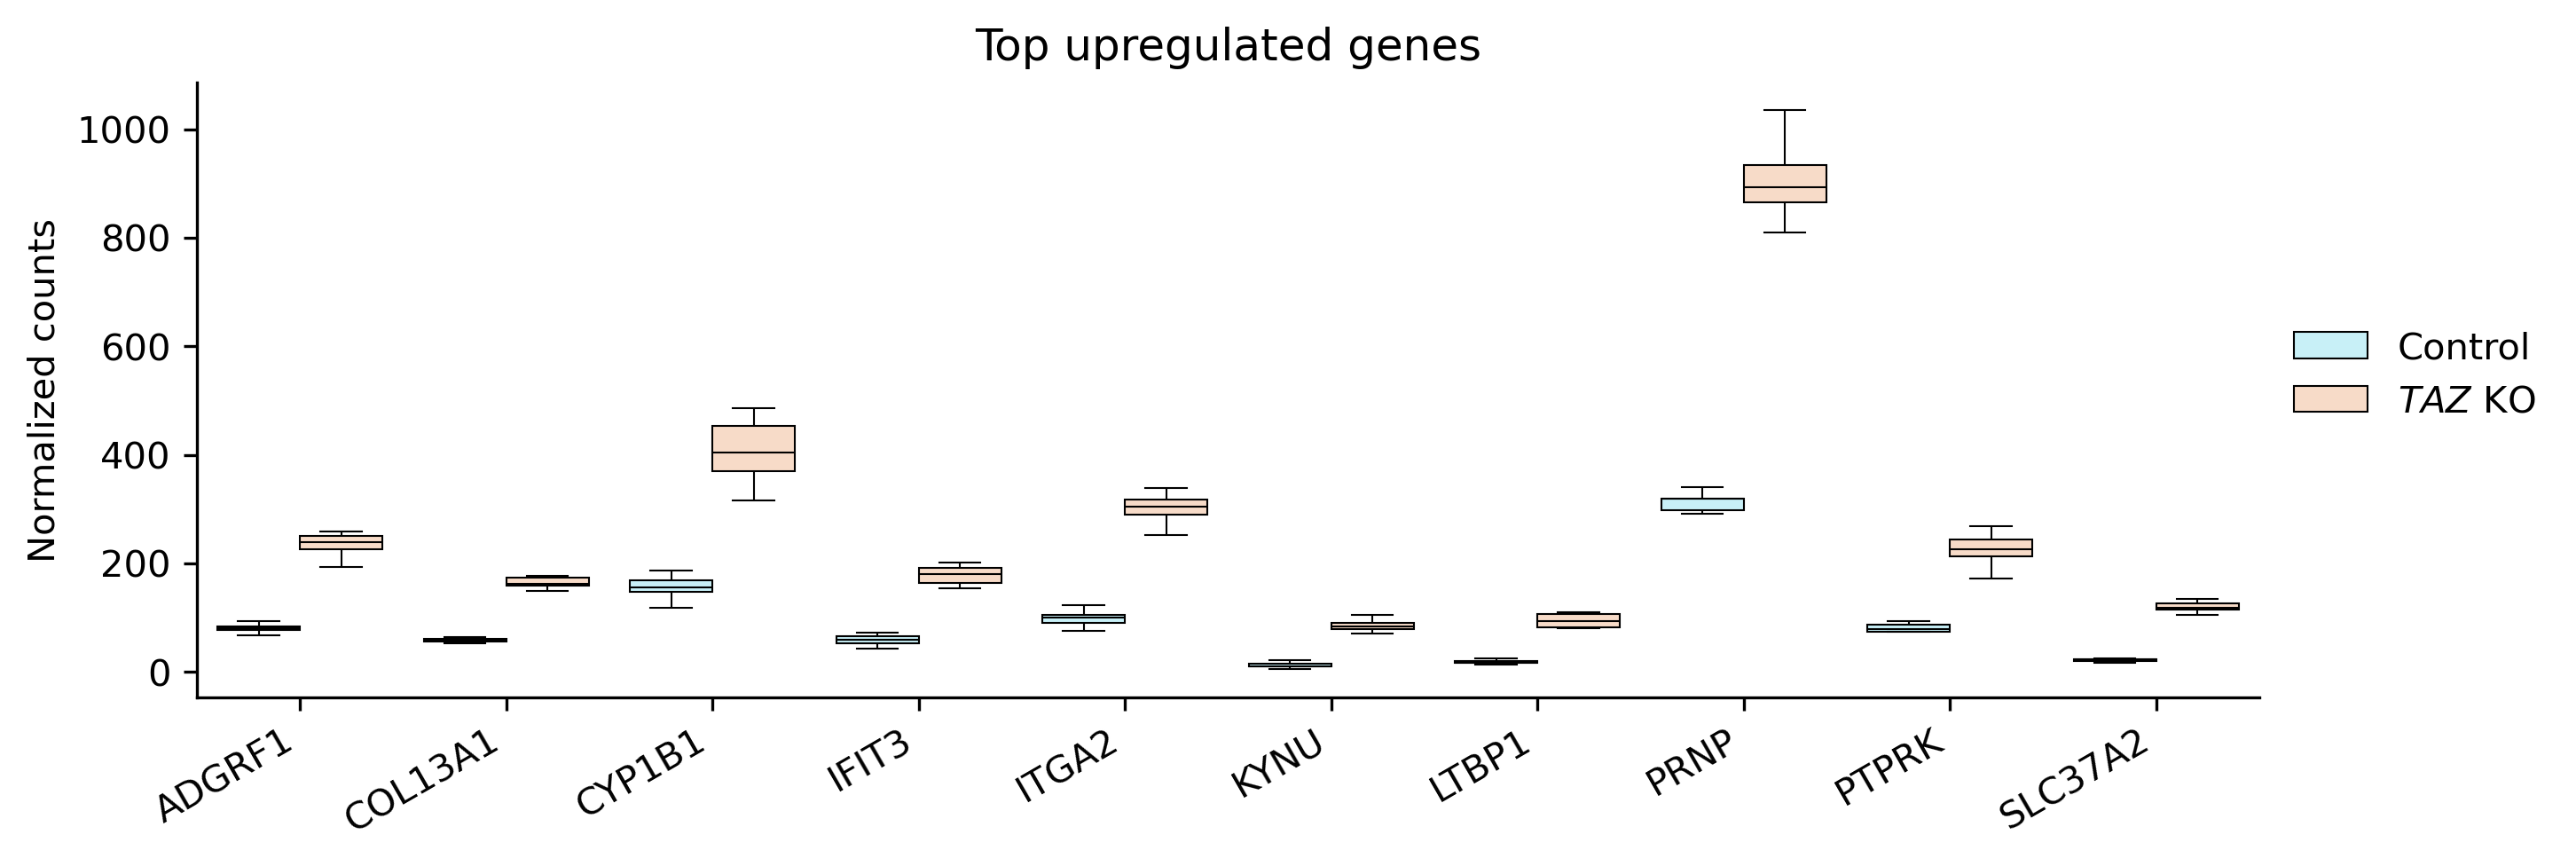

In [48]:
#Again for our box-plot we can just adapt our violin plot code
color_set = ['#C0F6FF', '#FFD9C0']
fig, ax = plt.subplots()

sns.boxplot(data=long_df_upreg,
            x='gene',
            y='count',
            hue='condition',
            palette=color_set,
            linewidth=0.5,
            linecolor='k',
            fliersize=False,
            log_scale=False,       #We can set y-scale to be log if we want better separation at the low counts
           )

handles, labels = ax.get_legend_handles_labels()
labels = ['Control', '$TAZ$ KO']

plt.legend(handles,
           labels,
           bbox_to_anchor=(1.15, 0.25, 0, 0.4),
           edgecolor='None',
          )

ax.set_xlabel(None)
ax.set_ylabel('Normalized counts')
ax.set_title('Top upregulated genes')
plt.xticks(rotation=30,
           ha='right',
          )

sns.despine()
fig.set_dpi(300)
fig.set_size_inches(10, 3)
plt.show()

fig.savefig('../Week_10/differential-expression-analysis/top10_upreg_genes_box-whisker_plot.pdf',
            bbox_inches='tight',
           )

<h2>Plot an annotated swarmplot for our upregulated genes</h2>

Now, let's go ahead and use our long form DataFrame for our annotated swarmplot to visualize our set of top 10 upregulated genes.

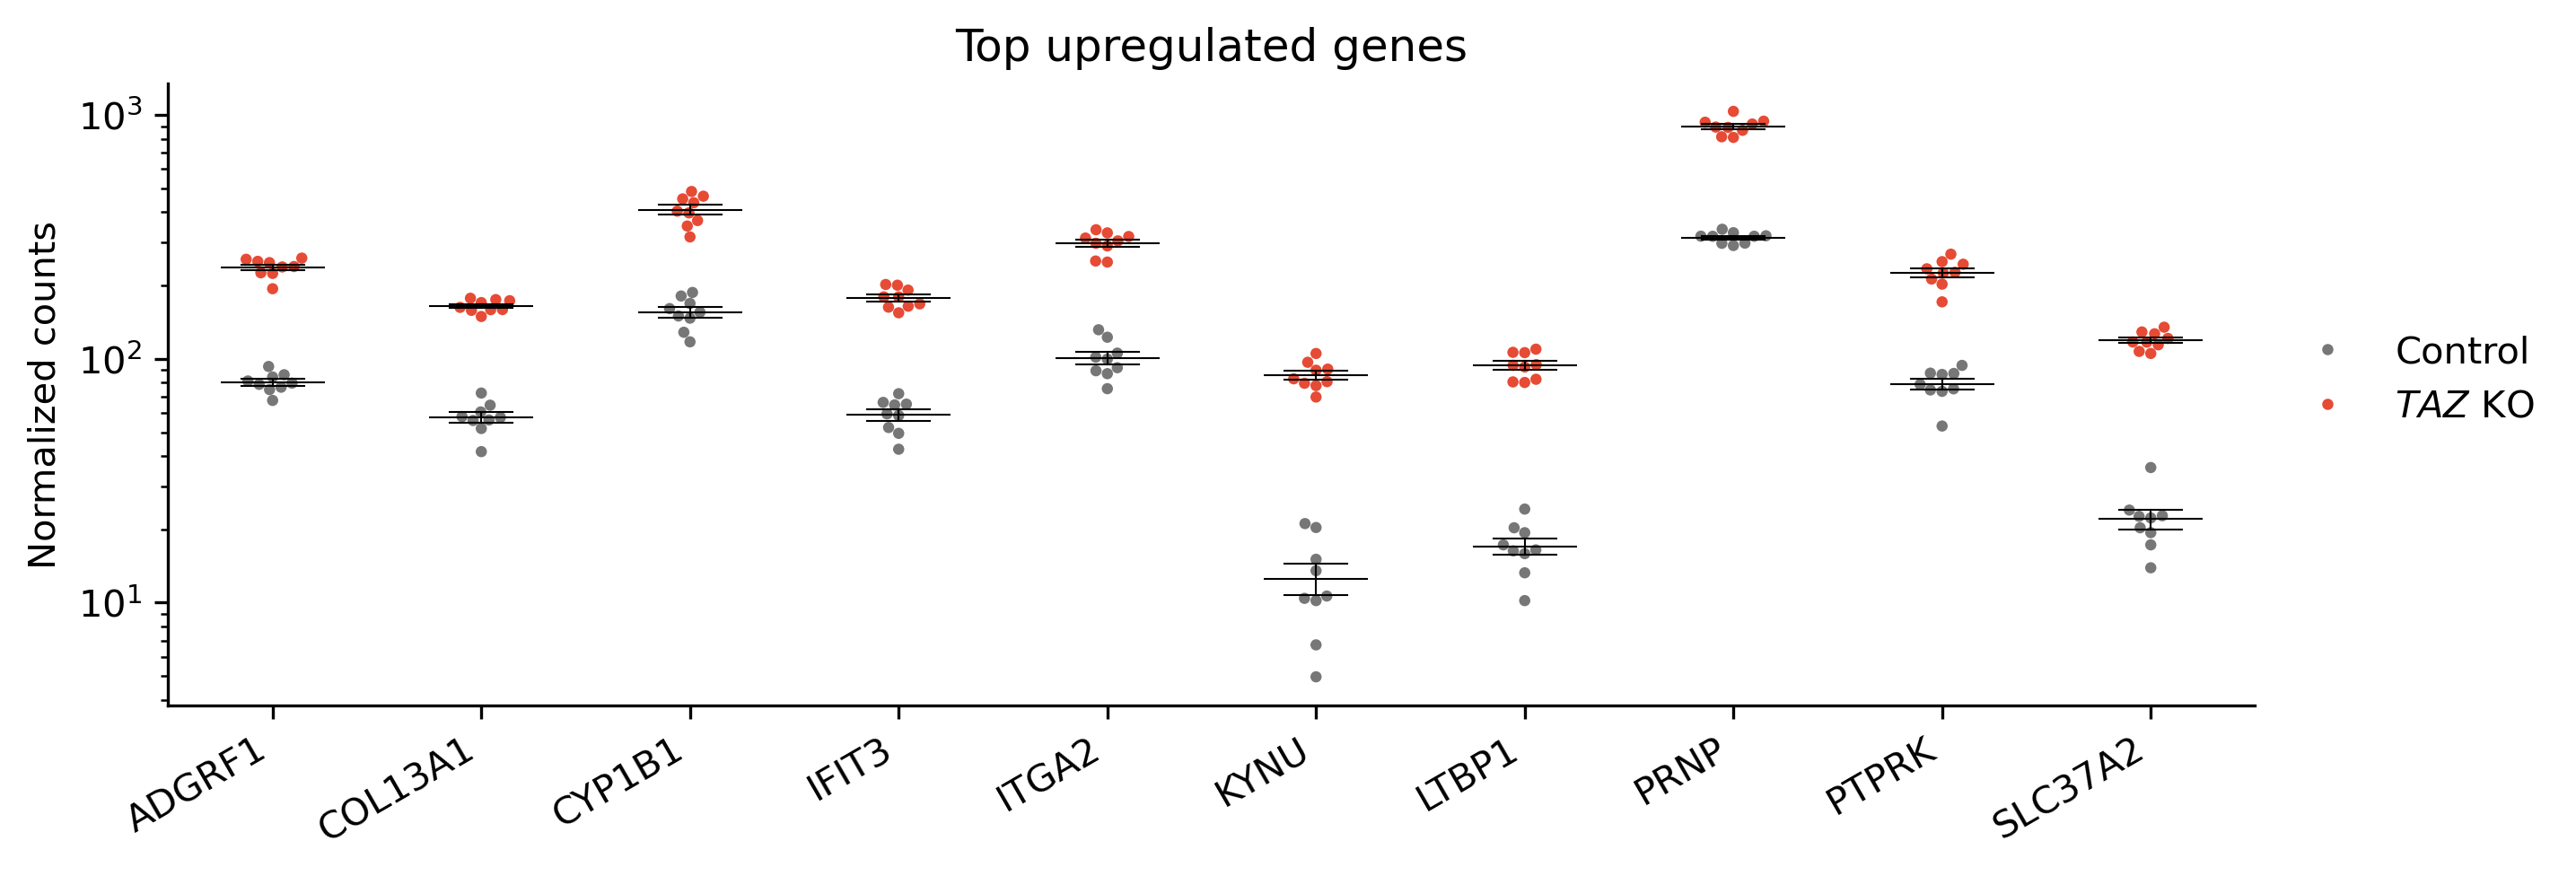

In [54]:
#And we can make use of the long format for our annotated swarm plot as well
#There's just some slight differences from the single-gene plot to align our 3 plot components better
color_set = ['#777777', '#E64B35']
fig, ax = plt.subplots()

sns.swarmplot(data=long_df_upreg,
              x='gene',
              y='count',
              hue='condition',
              palette=color_set,
              s=3,
              zorder=0,
             )

sns.barplot(data=long_df_upreg,
            x='gene',
            y='count',
            hue='condition',
            dodge=False,                    #We mush the bars together so it better aligns with the swarmplot
            estimator=np.mean,
            alpha=0,
            errorbar='se',
            capsize=0.3,
            err_kws={'linewidth' : 0.5,
                     'color' : 'k'
                    },
           )

sns.boxplot(data=long_df_upreg,
            x='gene',
            y='count',
            hue='condition',
            dodge=False,                    #Same here, we mush it together to align better
            showmeans=True,
            meanline=True,
            width=0.5,
            meanprops={'color' : 'k',
                       'linestyle' : '-',
                       'linewidth' : 0.5
                      },
            whiskerprops={'visible' : False},
            medianprops={'visible' : False},
            showfliers=False,
            showbox=False,
            showcaps=False,
           )

#Stylizing the plot is essentially the same as we did for our other plots
handles, labels = ax.get_legend_handles_labels()
labels = ['Control', '$TAZ$ KO']

plt.legend(handles,
           labels,
           bbox_to_anchor=(1.15, 0.25, 0, 0.4),
           edgecolor='None',
          )

ax.set_xlabel(None)
ax.set_ylabel('Normalized counts')
ax.set_title('Top upregulated genes')
plt.xticks(rotation=30,
           ha='right',
          )
plt.yscale('log')      #We can set log scale for y-axis here if we want better separation at lower counts

sns.despine()
fig.set_dpi(300)
fig.set_size_inches(10, 3)
plt.show()

fig.savefig('../Week_10/differential-expression-analysis/top10_upreg_genes_annotated_swarmplot.pdf',
            bbox_inches='tight',
           )